In [1]:
import os

# select the first GPU
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [2]:
import sys

sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2

from gpx.regression import sgpr_fit, sgpr_predict, sgpr_optimize
from gpx.kernels import se_kernel, kmap

In [4]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax import vmap, grad, jit

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
train_x = jnp.linspace(0, 1, 100)
key = random.PRNGKey(0)
train_y = jnp.sin(train_x * (2 * jnp.pi)) + random.normal(key, shape=train_x.shape) * jnp.sqrt(0.04)
test_x = jnp.linspace(-0.5, 1.5, 51)
test_y = jnp.sin(test_x * (2 * jnp.pi)) + random.normal(key, shape=test_x.shape) * jnp.sqrt(0.04)

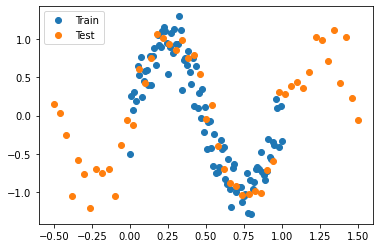

In [7]:
plt.plot(train_x, train_y, 'o', label='Train')
plt.plot(test_x, test_y, 'o', label='Test')
plt.legend()

# No optimization of input locations

In [8]:
# parameters
# Note that by not including 'x_locs' in the parameter dictionary, the locations are not optimized.

key = random.PRNGKey(2022)
x_locs = random.choice(key, train_x, shape=(2,), replace=False)

params = dict(
    sigma = 0.5,
    kernel_params=dict(lengthscale = 1.0),
)

In [9]:
c, y_mean = sgpr_fit(params, train_x, train_y, x_locs=x_locs, kernel=se_kernel)
locs_y_pred = sgpr_predict(params, x_locs, x_locs, c, y_mean, kernel=se_kernel, full_covariance=False)
train_y_pred, C_train = sgpr_predict(params, x_locs, train_x, c, y_mean, kernel=se_kernel, full_covariance=True)
test_y_pred, C_test = sgpr_predict(params, x_locs, test_x, c, y_mean, kernel=se_kernel, full_covariance=True)
train_conf = 2 * jnp.sqrt(jnp.diag(C_train))
test_conf = 2 * jnp.sqrt(jnp.diag(C_test))

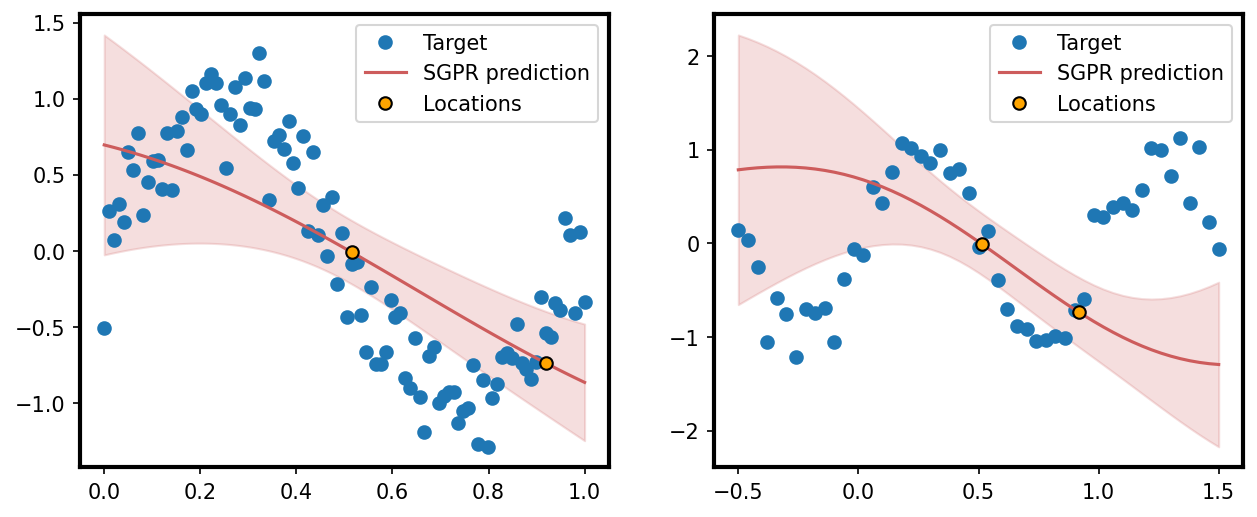

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(5*2, 4), dpi=150)
[[b.set_linewidth(2) for b in ax.spines.values()] for ax in axes]

ax = axes[0]
ax.plot(train_x, train_y, 'o', label='Target')
ax.plot(train_x, train_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(train_x.reshape(-1), train_y_pred.reshape(-1) - train_conf, train_y_pred.reshape(-1) + train_conf, alpha=0.2, color='indianred')
ax.legend()

ax = axes[1]
ax.plot(test_x, test_y, 'o', label='Target')
ax.plot(test_x, test_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(test_x.reshape(-1), test_y_pred.reshape(-1) - test_conf, test_y_pred.reshape(-1) + test_conf, alpha=0.2, color='indianred')
ax.legend()

In [11]:
params = sgpr_optimize(params, train_x, train_y, x_locs, kernel=se_kernel, n_steps=4000, step_size=0.001, verbose=40)

 loss : 106.624
 loss : 104.698
 loss : 102.788
 loss : 100.899
 loss : 99.034
 loss : 97.198
 loss : 95.396
 loss : 93.632
 loss : 91.911
 loss : 90.237
 loss : 88.616
 loss : 87.052
 loss : 85.550
 loss : 84.116
 loss : 82.755
 loss : 81.473
 loss : 80.276
 loss : 79.170
 loss : 78.159
 loss : 77.246
 loss : 76.434
 loss : 75.721
 loss : 75.103
 loss : 74.574
 loss : 74.126
 loss : 73.752
 loss : 73.442
 loss : 73.189
 loss : 72.986
 loss : 72.824
 loss : 72.697
 loss : 72.599
 loss : 72.524
 loss : 72.469
 loss : 72.428
 loss : 72.398
 loss : 72.377
 loss : 72.362
 loss : 72.352
 loss : 72.345
 loss : 72.340
 loss : 72.337
 loss : 72.335
 loss : 72.334
 loss : 72.333
 loss : 72.332
 loss : 72.332
 loss : 72.332
 loss : 72.332
 loss : 72.332
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss : 72.331
 loss 

In [12]:
c, y_mean = sgpr_fit(params, train_x, train_y, x_locs=x_locs, kernel=se_kernel)
x_locs = params['x_locs'] if 'x_locs' in params else x_locs
locs_y_pred = sgpr_predict(params, x_locs, x_locs, c, y_mean, kernel=se_kernel, full_covariance=False)
train_y_pred, C_train = sgpr_predict(params, x_locs, train_x, c, y_mean, kernel=se_kernel, full_covariance=True)
test_y_pred, C_test = sgpr_predict(params, x_locs, test_x, c, y_mean, kernel=se_kernel, full_covariance=True)
train_conf = 2 * jnp.sqrt(jnp.diag(C_train))
test_conf = 2 * jnp.sqrt(jnp.diag(C_test))

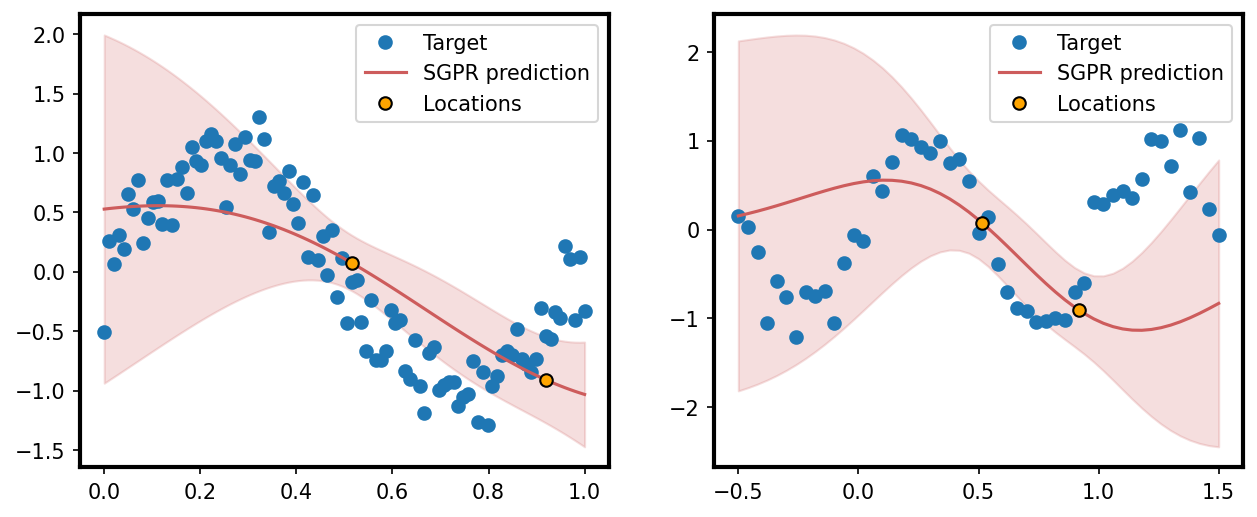

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(5*2, 4), dpi=150)
[[b.set_linewidth(2) for b in ax.spines.values()] for ax in axes]

ax = axes[0]
ax.plot(train_x, train_y, 'o', label='Target')
ax.plot(train_x, train_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(train_x.reshape(-1), train_y_pred.reshape(-1) - train_conf, train_y_pred.reshape(-1) + train_conf, alpha=0.2, color='indianred')
ax.legend()

ax = axes[1]
ax.plot(test_x, test_y, 'o', label='Target')
ax.plot(test_x, test_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(test_x.reshape(-1), test_y_pred.reshape(-1) - test_conf, test_y_pred.reshape(-1) + test_conf, alpha=0.2, color='indianred')
ax.legend()

## Optimization of input locations

In [14]:
# parameters
key = random.PRNGKey(2022)
x_locs = random.choice(key, train_x, shape=(2,), replace=False)

params = dict(
    sigma = 0.5,
    kernel_params=dict(lengthscale = 1.0),
    x_locs = x_locs,
)

In [15]:
c, y_mean = sgpr_fit(params, train_x, train_y, x_locs=x_locs, kernel=se_kernel)
locs_y_pred = sgpr_predict(params, x_locs, x_locs, c, y_mean, kernel=se_kernel, full_covariance=False)
train_y_pred, C_train = sgpr_predict(params, x_locs, train_x, c, y_mean, kernel=se_kernel, full_covariance=True)
test_y_pred, C_test = sgpr_predict(params, x_locs, test_x, c, y_mean, kernel=se_kernel, full_covariance=True)
train_conf = 2 * jnp.sqrt(jnp.diag(C_train))
test_conf = 2 * jnp.sqrt(jnp.diag(C_test))

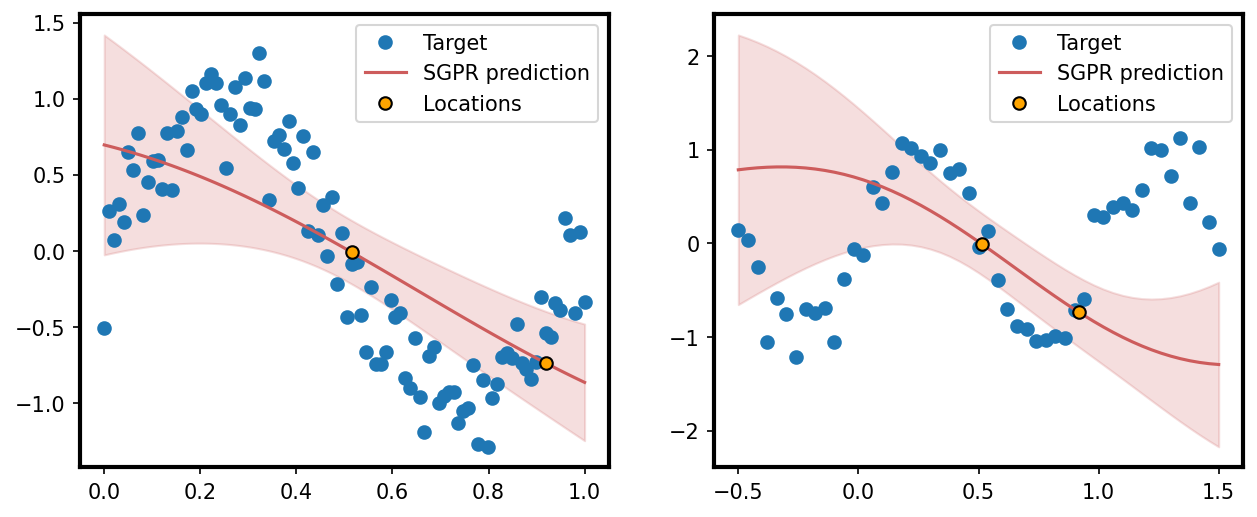

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(5*2, 4), dpi=150)
[[b.set_linewidth(2) for b in ax.spines.values()] for ax in axes]

x_locs = params['x_locs']

ax = axes[0]
ax.plot(train_x, train_y, 'o', label='Target')
ax.plot(train_x, train_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(train_x.reshape(-1), train_y_pred.reshape(-1) - train_conf, train_y_pred.reshape(-1) + train_conf, alpha=0.2, color='indianred')
ax.legend()

ax = axes[1]
ax.plot(test_x, test_y, 'o', label='Target')
ax.plot(test_x, test_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(test_x.reshape(-1), test_y_pred.reshape(-1) - test_conf, test_y_pred.reshape(-1) + test_conf, alpha=0.2, color='indianred')
ax.legend()

In [17]:
params = sgpr_optimize(params, train_x, train_y, x_locs, kernel=se_kernel, n_steps=4000, step_size=0.001, verbose=40)

 loss : 106.622
 loss : 104.609
 loss : 102.611
 loss : 100.632
 loss : 98.675
 loss : 96.743
 loss : 94.838
 loss : 92.959
 loss : 91.105
 loss : 89.270
 loss : 87.450
 loss : 85.637
 loss : 83.821
 loss : 81.991
 loss : 80.131
 loss : 78.222
 loss : 76.236
 loss : 74.140
 loss : 71.888
 loss : 69.427
 loss : 66.701
 loss : 63.620
 loss : 60.124
 loss : 56.159
 loss : 51.711
 loss : 46.839
 loss : 41.748
 loss : 36.611
 loss : 31.797
 loss : 27.564
 loss : 23.983
 loss : 20.965
 loss : 18.358
 loss : 16.040
 loss : 13.944
 loss : 12.045
 loss : 10.332
 loss : 8.798
 loss : 7.435
 loss : 6.235
 loss : 5.189
 loss : 4.288
 loss : 3.520
 loss : 2.872
 loss : 2.334
 loss : 1.892
 loss : 1.533
 loss : 1.247
 loss : 1.021
 loss : 0.845
 loss : 0.710
 loss : 0.608
 loss : 0.532
 loss : 0.477
 loss : 0.436
 loss : 0.407
 loss : 0.387
 loss : 0.372
 loss : 0.363
 loss : 0.356
 loss : 0.351
 loss : 0.348
 loss : 0.347
 loss : 0.345
 loss : 0.344
 loss : 0.344
 loss : 0.344
 loss : 0.343
 loss :

In [18]:
x_locs = params['x_locs']

c, y_mean = sgpr_fit(params, train_x, train_y, x_locs=x_locs, kernel=se_kernel)
locs_y_pred = sgpr_predict(params, x_locs, x_locs, c, y_mean, kernel=se_kernel, full_covariance=False)
train_y_pred, C_train = sgpr_predict(params, x_locs, train_x, c, y_mean, kernel=se_kernel, full_covariance=True)
test_y_pred, C_test = sgpr_predict(params, x_locs, test_x, c, y_mean, kernel=se_kernel, full_covariance=True)
train_conf = 2 * jnp.sqrt(jnp.diag(C_train))
test_conf = 2 * jnp.sqrt(jnp.diag(C_test))

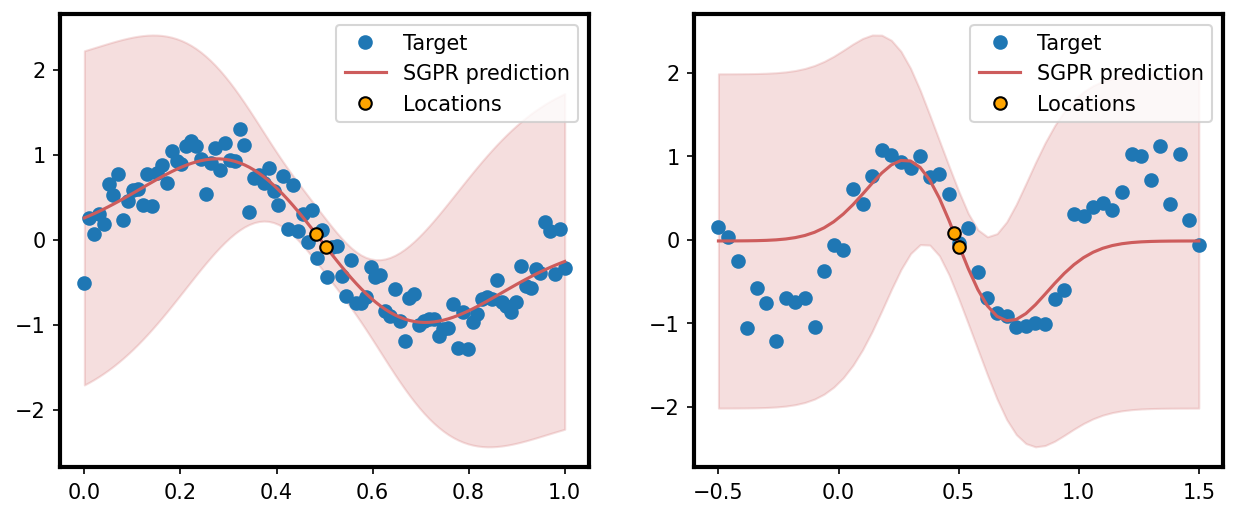

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(5*2, 4), dpi=150)
[[b.set_linewidth(2) for b in ax.spines.values()] for ax in axes]

x_locs = params['x_locs']

ax = axes[0]
ax.plot(train_x, train_y, 'o', label='Target')
ax.plot(train_x, train_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(train_x.reshape(-1), train_y_pred.reshape(-1) - train_conf, train_y_pred.reshape(-1) + train_conf, alpha=0.2, color='indianred')
ax.legend()

ax = axes[1]
ax.plot(test_x, test_y, 'o', label='Target')
ax.plot(test_x, test_y_pred, color='indianred', label='SGPR prediction')
ax.plot(x_locs, locs_y_pred, 'o', color='orange', mec='k', label='Locations')
ax.fill_between(test_x.reshape(-1), test_y_pred.reshape(-1) - test_conf, test_y_pred.reshape(-1) + test_conf, alpha=0.2, color='indianred')
ax.legend()